In [1]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from Bio import SeqIO

import numpy as np
import pandas as pd
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe"
os.makedirs(MODEL_BASE_DIR,exist_ok=True)
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

In [3]:
# Load model
from src.featurizers import MorganFeaturizer, ProtBertFeaturizer
from src.architectures import SimpleCoembedding

# Set device
device = torch.device(5)

# Load featurizers
mol_f = MorganFeaturizer().cuda(device)
prot_f = ProtBertFeaturizer().cuda(device)

def get_drug_feature(x):
    with torch.set_grad_enabled(False):
        return mol_f(x).squeeze().detach().cpu().numpy()
        
def get_target_feature(x):
    with torch.set_grad_enabled(False):
        return prot_f(x).squeeze().detach().cpu().numpy()

## Load DUD-E Data

In [4]:
splits = pd.read_csv('../dataset/DUDe/dude_within_type_train_test_split.csv',header=None,names=['Target','Split'])
splits.head()

,Target,Split
0,fa7,train
1,bace1,train
2,mmp13,train
3,ace,train
4,tryb1,train


In [5]:
train_targets = splits[splits.Split == 'train'].Target.values
test_targets = splits[splits.Split == 'test'].Target.values

In [6]:
active_dfs = {}
decoy_dfs = {}
link_dfs = {}

def get_sequence_from_pdb(target_path):
    warnings.filterwarnings('ignore')
    recs = list(SeqIO.parse(target_path, "pdb-atom"))
    return str(recs[0].seq)

for tid in tqdm(splits.Target):
    tseq = get_sequence_from_pdb(f'{DATA_DIR}/{tid}/receptor.pdb')
    actives_frame = PandasTools.LoadSDF(f'{DATA_DIR}/{tid}/actives_final.sdf',
                                        smilesName='SMILES',molColName=None,includeFingerprints=True).drop_duplicates()
    decoys_frame = PandasTools.LoadSDF(f'{DATA_DIR}/{tid}/decoys_final.sdf',
                                        smilesName='SMILES',molColName=None,includeFingerprints=True).drop_duplicates()

    links = []
    for _, row in actives_frame.iterrows():
        links.append((tid, tseq, row.ID, row.SMILES, 1))
    for _, row in decoys_frame.iterrows():
        links.append((tid, tseq, row.ID, row.SMILES, 0))
    df = pd.DataFrame(links)
    
    active_dfs[tid] = actives_frame
    decoy_dfs[tid] = decoys_frame
    link_dfs[tid] = df

  0%|          | 0/57 [00:00<?, ?it/s]

[11:21:01] Explicit valence for atom # 7 N, 5, is greater than permitted
[11:21:01] ERROR: Could not sanitize molecule ending on line 3875828
[11:21:01] ERROR: Explicit valence for atom # 7 N, 5, is greater than permitted
[11:26:17] Explicit valence for atom # 9 N, 5, is greater than permitted
[11:26:17] ERROR: Could not sanitize molecule ending on line 1034433
[11:26:17] ERROR: Explicit valence for atom # 9 N, 5, is greater than permitted
[11:26:28] Explicit valence for atom # 7 N, 5, is greater than permitted
[11:26:28] ERROR: Could not sanitize molecule ending on line 586033
[11:26:28] ERROR: Explicit valence for atom # 7 N, 5, is greater than permitted
[11:27:05] Explicit valence for atom # 7 N, 5, is greater than permitted
[11:27:05] ERROR: Could not sanitize molecule ending on line 1169873
[11:27:05] ERROR: Explicit valence for atom # 7 N, 5, is greater than permitted


In [32]:
train_df = pd.concat([link_dfs[i] for i in train_targets])
test_df = pd.concat([link_dfs[i] for i in test_targets])

In [46]:
train_df

,0,1,2,3,4
0,fa7,IVGGKVCPKGECPWQVLLLVNGAQLCGGTLINTIWVVSAAHCFDKI...,CHEMBL178616,COc1cc([C@@H](Nc2ccc(C(N)=[NH2+])cc2)C(=O)N[C@...,1
1,fa7,IVGGKVCPKGECPWQVLLLVNGAQLCGGTLINTIWVVSAAHCFDKI...,CHEMBL194689,C[N@@H+]1CCC[C@@H]1CCN(Cc1ccc2ccc(C(N)=[NH2+])...,1
2,fa7,IVGGKVCPKGECPWQVLLLVNGAQLCGGTLINTIWVVSAAHCFDKI...,CHEMBL194689,C[N@@H+]1CCC[C@H]1CCN(Cc1ccc2ccc(C(N)=[NH2+])c...,1
3,fa7,IVGGKVCPKGECPWQVLLLVNGAQLCGGTLINTIWVVSAAHCFDKI...,CHEMBL206232,Cc1cccc(NC(=O)Cc2cc([C@H](CC(=O)[O-])C(=O)[O-]...,1
4,fa7,IVGGKVCPKGECPWQVLLLVNGAQLCGGTLINTIWVVSAAHCFDKI...,CHEMBL206232,Cc1cccc(NC(=O)Cc2cc([C@H](CC(=O)[O-])C(=O)[O-]...,1
...,...,...,...,...,...
32779,aa2ar,IMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSL...,ZINC21665379,COc1ccc(C(=O)O[C@@H](C)C(=O)N2CCNC2=O)cc1S(=O)...,0
32780,aa2ar,IMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSL...,ZINC14160534,Cc1cc(C)nc(N/C(=N\C(=S)NC[C@H]2CCCO2)N2CCN(c3n...,0
32781,aa2ar,IMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSL...,ZINC21684426,C[C@@H](OC(=O)CNS(=O)(=O)/C=C/c1ccccc1)C(=O)Nc...,0
32782,aa2ar,IMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSL...,ZINC65743371,COC(=O)[C@]1(OC)C[C@H](O)[C@H](O)[C@H](COP(=O)...,0


In [52]:
all_targets = pd.concat([train_df, test_df])[[0,1]].drop_duplicates()
all_drugs = pd.concat([train_df, test_df])[[2,3]].drop_duplicates()

In [56]:
target_feats = {}
drug_feats = {}

for i, r in tqdm(all_targets.iterrows(),total=len(all_targets)):
    target_feats[r[0]] = get_target_feature(r[1])
for i, r in tqdm(all_drugs.iterrows(),total=len(all_drugs)):
    drug_feats[r[2]] = get_drug_feature(r[3])

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/808755 [00:00<?, ?it/s]

In [57]:
train_X = np.stack([
    np.concatenate([target_feats[x], drug_feats[y]]) for (x,y) in zip(train_df[0].values, train_df[2].values)
])

train_Y = train_df[4]

In [58]:
test_X = np.stack([
    np.concatenate([get_target_feature(x), get_drug_feature(y)]) for (x,y) in zip(test_df[1].values, test_df[3].values)
])
test_Y = test_df[4]

In [66]:
np.save('../nbdata/DUDE_trainX.npz', train_X)
np.save('../nbdata/DUDE_trainY.npz', train_Y)
np.save('../nbdata/DUDE_testX.npz', test_X)
np.save('../nbdata/DUDE_testY.npz', test_Y)

## Load BIOSNAP Data

In [181]:
biosnap_train = pd.read_csv('../dataset/BIOSNAP/full_data/train.csv')
biosnap_test = pd.read_csv('../dataset/BIOSNAP/full_data/test.csv')

In [182]:
bs_targets = pd.concat([biosnap_train, biosnap_test])[['Gene', 'Target Sequence']].drop_duplicates()
bs_drugs = pd.concat([biosnap_train, biosnap_test])[['DrugBank ID', 'SMILES']].drop_duplicates()

bs_target_feats = {}
bs_drug_feats = {}

for i, r in tqdm(bs_targets.iterrows(),total=len(bs_targets)):
    bs_target_feats[r['Gene']] = get_target_feature(r['Target Sequence'])
for i, r in tqdm(bs_drugs.iterrows(),total=len(bs_drugs)):
    bs_drug_feats[r['DrugBank ID']] = get_drug_feature(r['SMILES'])

  0%|          | 0/2182 [00:00<?, ?it/s]

  0%|          | 0/4491 [00:00<?, ?it/s]

[21:22:05] Unusual charge on atom 0 number of radical electrons set to zero
[21:22:05] Unusual charge on atom 42 number of radical electrons set to zero


In [185]:
snap_train_X = np.stack([
    np.concatenate([bs_target_feats[x], bs_drug_feats[y]]) for (x,y) in zip(biosnap_train['Gene'].values, biosnap_train['DrugBank ID'].values)
])
snap_train_Y = biosnap_train['Label']

In [186]:
snap_test_X = np.stack([
    np.concatenate([bs_target_feats[x], bs_drug_feats[y]]) for (x,y) in zip(biosnap_test['Gene'].values, biosnap_test['DrugBank ID'].values)
])
snap_test_Y = biosnap_test['Label']

## Train Models

In [161]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier

In [156]:
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score

In [162]:
lr_model = LogisticRegression()
llr_model = LinearRegression()
mlp_model = MLPClassifier()

In [197]:
mlp_wide = MLPClassifier(hidden_layer_sizes=(1024),)

In [216]:
model_no_contrast_path = f"{MODEL_BASE_DIR}/new_api/testBIOSNAP-noContrast_best_model.pt"
model_contrast_path = f"{MODEL_BASE_DIR}/new_api/testBIOSNAP_best_model.pt"

# Load model
model_noCon = SimpleCoembedding(mol_f.shape, prot_f.shape, 1024).to(device)
model_Con = SimpleCoembedding(mol_f.shape, prot_f.shape, 1024).to(device)

model_noCon.load_state_dict(torch.load(model_no_contrast_path))
model_Con.load_state_dict(torch.load(model_contrast_path))

<All keys matched successfully>

In [217]:
def dti_model_predict(x, model,
                      t_shape = prot_f.shape,
                      d_shape = mol_f.shape,
                      device = device
                     ):
    assert t_shape + d_shape == x.shape[1]
    with torch.set_grad_enabled(False):
        t_embed = torch.from_numpy(x[:,:t_shape]).to(device)
        d_embed = torch.from_numpy(x[:,-d_shape:]).to(device)
        phat = model(d_embed, t_embed).detach().cpu().numpy()
        return phat

In [166]:
lr_model.fit(train_X, train_Y)
llr_model.fit(train_X, train_Y)
mlp_model.fit(train_X, train_Y)

MLPClassifier()

In [198]:
mlp_wide.fit(train_X, train_Y)

MLPClassifier(hidden_layer_sizes=1024)

## Evaluate on DUDe

In [190]:
def binarize(x,t):
    return (x >= t).astype(int)

def fdr(y, phat):
    return 1 - precision_score(y, phat)

In [218]:
lr_predictions = lr_model.predict(test_X)
llr_predictions = llr_model.predict(test_X)
mlp_predictions = mlp_model.predict(test_X)
mlp_wide_predictions = mlp_wide.predict(test_X)
nocon_predictions = dti_model_predict(test_X, model_noCon)
contrast_predictions = dti_model_predict(test_X, model_Con)

AUPR (Logistic): 0.2567557623925064
AUPR (MLP): 0.2830099655363373
AUPR (MLP Wide): 0.3061420261866066
AUPR (DTI): 0.0763327537889308
AUPR (DTI Contrastive): 0.4527715949137886


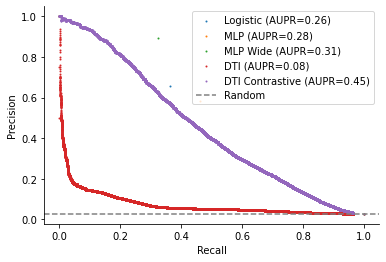

AUROC (Logistic): 0.679569579984269
AUROC (MLP): 0.7263786158319168
AUROC (MLP Wide): 0.6609616100342529
AUROC (DTI): 0.6719236315478887
AUROC (DTI Contrastive): 0.8861448700527281


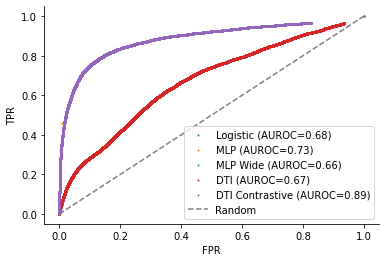

In [219]:
model_predictions = {
    'Logistic': lr_predictions,
    'MLP': mlp_predictions,
    'MLP Wide': mlp_wide_predictions,
    'DTI': nocon_predictions,
    'DTI Contrastive': contrast_predictions,
}

model_metrics = {}

for m_name, m_predictions in model_predictions.items():
    aupr = average_precision_score(test_Y, m_predictions)
    roc = roc_auc_score(test_Y, m_predictions)
    prc, rec, thr = precision_recall_curve(test_Y, m_predictions)
    fpr, tpr, thr = roc_curve(test_Y, m_predictions)
    model_metrics[m_name] = (aupr, roc, prc, rec, fpr, tpr)
    
    print(f'AUPR ({m_name}): {aupr}')
    plt.scatter(rec, prc, label=f'{m_name} (AUPR={aupr:.2f})',s=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axhline(test_Y.sum() / len(test_Y), linestyle='--', color='gray', label='Random')
plt.legend()
sns.despine()
plt.show()

for m_name in model_predictions.keys():
    aupr, roc, prc, rec, fpr, tpr = model_metrics[m_name]
    print(f'AUROC ({m_name}): {roc}')
    plt.scatter(fpr, tpr, label=f'{m_name} (AUROC={roc:.2f})',s=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random')
plt.legend()
sns.despine()
plt.show()

## Evaluate on BIOSNAP

In [204]:
snap_lr_predictions = lr_model.predict(snap_test_X)
snap_llr_predictions = llr_model.predict(snap_test_X)
snap_mlp_predictions = mlp_model.predict(snap_test_X)
snap_mlp_wide_predictions = mlp_wide.predict(snap_test_X)
snap_nocon_predictions = dti_model_predict(snap_test_X, model_noCon)
snap_contrast_predictions = dti_model_predict(snap_test_X, model_Con)

AUPR (Logistic): 0.49521211604938986
AUPR (MLP): 0.5010669507273576
AUPR (MLP Wide): 0.5059352110964574
AUPR (DTI): 0.8979610401256449
AUPR (DTI Contrastive): 0.8968186017623122


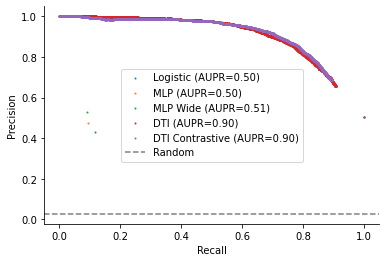

AUROC (Logistic): 0.4796311520442056
AUROC (MLP): 0.49394562199902303
AUROC (MLP Wide): 0.5038750746314101
AUROC (DTI): 0.8772934513667974
AUROC (DTI Contrastive): 0.880189414850029


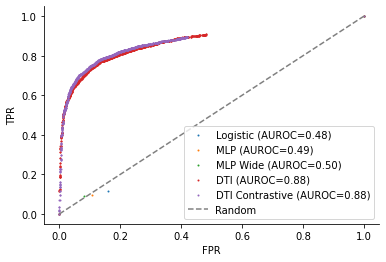

In [205]:
model_predictions = {
    'Logistic': snap_lr_predictions,
    'MLP': snap_mlp_predictions,
    'MLP Wide': snap_mlp_wide_predictions,
    'DTI': snap_nocon_predictions,
    'DTI Contrastive': snap_contrast_predictions,
}
model_metrics = {}

for m_name, m_predictions in model_predictions.items():
    aupr = average_precision_score(snap_test_Y, m_predictions)
    roc = roc_auc_score(snap_test_Y, m_predictions)
    prc, rec, thr = precision_recall_curve(snap_test_Y, m_predictions)
    fpr, tpr, thr = roc_curve(snap_test_Y, m_predictions)
    model_metrics[m_name] = (aupr, roc, prc, rec, fpr, tpr)
    
    print(f'AUPR ({m_name}): {aupr}')
    plt.scatter(rec, prc, label=f'{m_name} (AUPR={aupr:.2f})',s=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axhline(test_Y.sum() / len(test_Y), linestyle='--', color='gray', label='Random')
plt.legend()
sns.despine()
plt.show()

for m_name in model_predictions.keys():
    aupr, roc, prc, rec, fpr, tpr = model_metrics[m_name]
    print(f'AUROC ({m_name}): {roc}')
    plt.scatter(fpr, tpr, label=f'{m_name} (AUROC={roc:.2f})',s=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random')
plt.legend()
sns.despine()
plt.show()